In [ ]:
import cv2
import numpy as np
import pandas as pd

from google.colab.patches import cv2_imshow
# Load the original image and the centroids data
original_image_path = 'top_down_view.png'
centroid_data_path = 'for_eric.csv'

# Read the centroids data
centroids = pd.read_csv(centroid_data_path)

# Load the original image
original_image = cv2.imread(original_image_path)

In [ ]:

def get_line_length(line):
    x1, y1, x2, y2 = line
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Load image
image = original_image

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a mask to isolate white areas
# You might need to adjust the thresholds according to your image's lighting conditions
mask = cv2.inRange(gray, 200, 255)

# Use Canny edge detection
edges = cv2.Canny(mask, 50, 150, apertureSize=3)

# Use Hough Line Transform to find lines
#lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=5, maxLineGap=20)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=5, maxLineGap=20)

# Filter out lines based on orientation (horizontal or vertical)
horizontal_lines = []
vertical_lines = []


angle_threshold = 10  # degrees

for line in lines:
    for x1, y1, x2, y2 in line:
        angle = np.arctan2((y2 - y1), (x2 - x1)) * (180 / np.pi)
        if angle < -angle_threshold or angle > angle_threshold:
            vertical_lines.append(line[0])
        if angle > -90 + angle_threshold and angle < 90 - angle_threshold:
            horizontal_lines.append(line[0])

# Check if any vertical lines were detected and compute the mean if so
if vertical_lines:
    average_vertical_length = np.mean([get_line_length(line) for line in vertical_lines])
else:
    average_vertical_length = 0


# Calculate average lengths
average_horizontal_length = np.mean([get_line_length(line) for line in horizontal_lines])
average_vertical_length = np.mean([get_line_length(line) for line in vertical_lines])

width = int(average_horizontal_length/2)

height = int(average_vertical_length)

print(f"Average horizontal line length (parking spot width): {width}")
print(f"Average vertical line length (parking spot height): {height}")


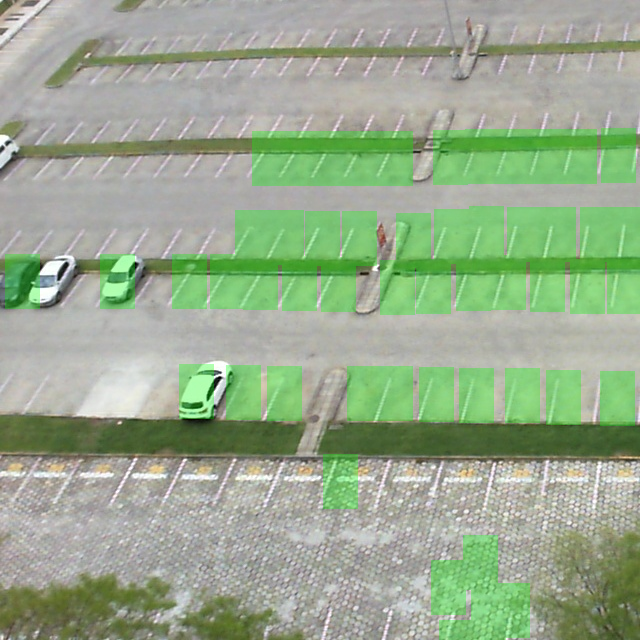

In [ ]:
overlay = original_image.copy()
for index, row in centroids.iterrows():
    center_x, center_y = int(row['x-pixel']), int(row['y-pixel'])
    #width, height = 50, 100  # these should be adjusted to the actual size of the parking spots
    top_left_corner = (center_x - width // 2, center_y - height // 2)
    bottom_right_corner = (center_x + width // 2, center_y + height // 2)
    cv2.rectangle(overlay, top_left_corner, bottom_right_corner, (0, 255, 0), -1)  # -1 fills the rectangle
alpha = 0.3  # transparency factor
cv2.addWeighted(overlay, alpha, original_image, 1 - alpha, 0, original_image)

cv2_imshow(original_image)
